In [3]:
import os

import torch.nn as nn
import torch.nn.functional as F
import numpy as np


import multiprocessing as mp
from my_models.age_sex_pred import *
from utils.result_analysis import *
import pickle
import dm_model.dm_models as dmm
import dm_model.dm_utils as dmu
import dm_model.dm_dataset as dmd
import dm_model.dm_loss as dml
import dm_model.dm_train as dmt
import dm_model.dm_visualisation as dmv
import importlib
importlib.reload(dmm)
importlib.reload(dmd)
import pickle
import collections
import re

import nibabel
from sklearn.cluster import KMeans

/users/win-biobank/jdo465/anaconda3/envs/pytorch_1_0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Age-Sex Prediction Module imported.2019-03-14 16:31:01
Config I/O Module imported.2019-03-14 16:31:01


In [4]:
import time
def tic():
    global t_tic_tag
    t_tic_tag = time.time()
def toc():
    global t_tic_tag
    dt = time.time() - t_tic_tag
    print('Elapsed time %f seconds'%dt)
    return dt

# Clean the data and create 4D matrix for PCA

## Clean fmrib_info

In [3]:
config = dmu.Configurations('/well/win-biobank/users/jdo465/age_sex_prediction/run_20190304_01/config.ini')
fmrib_info = pd.read_csv(dmd.UKBiobankSubjects(config).fmrib_info_path)

In [66]:
dmd.UKBiobankSubjects(config).fmrib_info_path

'/well/win-biobank/users/jdo465/age_sex_prediction/fmrib_info.csv'

In [8]:
sbj = dmd.UKBiobankSubjects(config)

In [9]:
sbj.selected_image_path

'/well/win-biobank/users/jdo465/age_sex_prediction/SubjectsAll/5287566/T1/T1_brain_linearto_MNI.nii.gz'

In [10]:
dirs = os.listdir('/well/win-biobank/users/jdo465/age_sex_prediction/SubjectsAll/')

In [45]:
osp.join('/well/win-biobank/users/jdo465/age_sex_prediction/SubjectsAll/','%d'%idx,'T1/T1_brain_linearto_MNI.nii.gz')

'/well/win-biobank/users/jdo465/age_sex_prediction/SubjectsAll/6025432/T1/T1_brain_linearto_MNI.nii.gz'

In [46]:
for idx in fmrib_info.No:
    path = osp.join('/well/win-biobank/users/jdo465/age_sex_prediction/SubjectsAll/','%d'%idx,'T1/T1_brain_linearto_MNI.nii.gz')
    if not osp.isfile(path):
        print(idx)

2519631.0


In [67]:
fmrib_info_clean = fmrib_info.drop(index=fmrib_info.loc[fmrib_info.No==2519631.0].index)
print(fmrib_info.shape)
print(fmrib_info_clean.shape)
fmrib_info_clean.to_csv('/well/win-biobank/users/jdo465/age_sex_prediction/fmrib_info_clean.csv')

(14504, 6)
(14503, 6)


## Load and clean

In [7]:
data_init = np.random.rand(1000, 160, 192, 160)

In [3]:
import os

import torch.nn as nn
import torch.nn.functional as F
import numpy as np


import multiprocessing as mp
from my_models.age_sex_pred import *
from utils.result_analysis import *
import pickle
import dm_model.dm_models as dmm
import dm_model.dm_utils as dmu
import dm_model.dm_dataset as dmd
import dm_model.dm_loss as dml
import dm_model.dm_train as dmt
import dm_model.dm_visualisation as dmv
import importlib
importlib.reload(dmm)
importlib.reload(dmd)
import pickle
import collections
import re

import nibabel
from sklearn.cluster import KMeans

import time


def tic():
    global t_tic_tag
    t_tic_tag = time.time()
def toc():
    global t_tic_tag
    dt = time.time() - t_tic_tag
    print('Elapsed time %f seconds'%dt)
    return dt


N = dmd.FMRIB_INFO_CLEAN_DF.shape[0]
log_interval = 100

N_init = 2000


subject_folder = '/well/win-biobank/users/jdo465/age_sex_prediction/SubjectsAll/'
total_count = np.prod((160, 192, 160))
x_crop = int((182-160)/2)
y_crop = int((218-192)/2)
z_crop = int((182-160)/2)

print('==== Build Initial Data Matrix to Calculate Non-zero Mask ====')
data_init = np.zeros((N_init, 160, 192, 160), dtype=np.float32)
tic()
for i in range(N_init):
    idx = dmd.FMRIB_INFO_CLEAN_DF.No.values[i]
    selected_image_path = osp.join(subject_folder, '%d'%idx, 'T1/T1_brain_linearto_MNI.nii.gz')
    data = nibabel.load(selected_image_path).get_fdata(dtype=np.float32)[x_crop:-x_crop, y_crop:-y_crop, z_crop:-z_crop]
    data_init[i] = data/data.mean()    
    if (i+1)%log_interval==0:      
        zero_count = np.sum(np.sum(data_init, axis=0)==0)    
        print('Loaded %d: Zeros %d, All %d' % (i+1, zero_count, total_count))
        dt = toc()
        tic()
        print('Time left %.3fs' % (dt*(N_init-i-1)/log_interval))

        
mask_0 = np.sum(data_init, axis=0)!=0
n_non_zero = np.sum(mask_0)
mask = (mask_0.reshape([1, 160, 192, 160]).repeat(N_init, axis=0))


print('==== Load the rest of data ====')

data_all = np.zeros((N, n_non_zero), dtype=np.float32)
data_all[:N_init] = data_init[mask].reshape([N_init, -1])

tic()
for i in range(N_init, N): 
    idx = dmd.FMRIB_INFO_CLEAN_DF.No.values[i]
    selected_image_path = osp.join(subject_folder, '%d'%idx, 'T1/T1_brain_linearto_MNI.nii.gz')
    data = nibabel.load(selected_image_path).get_fdata(dtype=np.float32)[x_crop:-x_crop, y_crop:-y_crop, z_crop:-z_crop][mask_0]
    data /= data.mean()
    data_all[i] = data
    if (i+1)%log_interval==0:
        print('Loaded %d' % (i+1, ))
        dt = toc()
        tic()
        print('Time left %.3fs' % (dt*(N-i-1)/log_interval))

print('==== Save data ====')
save_path = '/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1.npy'
save_path_mask = '/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1_nonzero_mask.npy'
with open(save_path, 'wb') as f:
    np.save(f, data_all)
with open(save_path_mask, 'wb') as f:
    np.save(f, mask_0)
print('Done. Saved at %s' % save_path)

==== Build Initial Data Matrix to Calculate Non-zero Mask ====
Loaded 100: Zeros 2500395, All 4915200
Elapsed time 33.648146 seconds
Time left 639.315s
Loaded 200: Zeros 2473149, All 4915200
Elapsed time 30.976055 seconds
Time left 557.569s
Loaded 300: Zeros 2425041, All 4915200
Elapsed time 33.694605 seconds
Time left 572.808s
Loaded 400: Zeros 2414912, All 4915200
Elapsed time 34.109246 seconds
Time left 545.748s
Loaded 500: Zeros 2390847, All 4915200
Elapsed time 34.194300 seconds
Time left 512.914s
Loaded 600: Zeros 2383025, All 4915200
Elapsed time 34.428785 seconds
Time left 482.003s
Loaded 700: Zeros 2373694, All 4915200
Elapsed time 31.152037 seconds
Time left 404.976s
Loaded 800: Zeros 2370412, All 4915200
Elapsed time 34.248565 seconds
Time left 410.983s
Loaded 900: Zeros 2352320, All 4915200
Elapsed time 33.870778 seconds
Time left 372.579s
Loaded 1000: Zeros 2349040, All 4915200
Elapsed time 34.796505 seconds
Time left 347.965s
Loaded 1100: Zeros 2341794, All 4915200
Elapse

## Now, Load data and PCA

In [3]:
tic()
data_all = np.load('/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1.npy')
toc();

path_train = '/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1_5600.npy'
path_test = '/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1_5600_6600.npy'

data_train = data_all[:5600]
data_test = data_all[5600:6600]

np.save(path_train, data_train)
np.save(path_test, data_test)

del data_all
del data_train
del data_test

mask_0 = np.load('/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1_nonzero_mask.npy')

Elapsed time 116.917655 seconds


In [6]:
tic()
data_train = np.load(path_train)
data_test = np.load(path_test)
toc();

Elapsed time 51.821980 seconds


### Verify

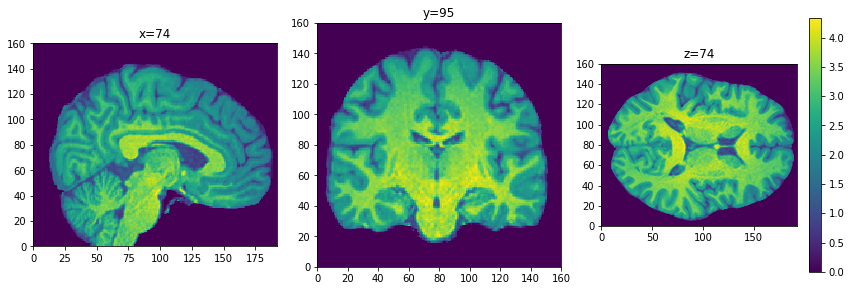

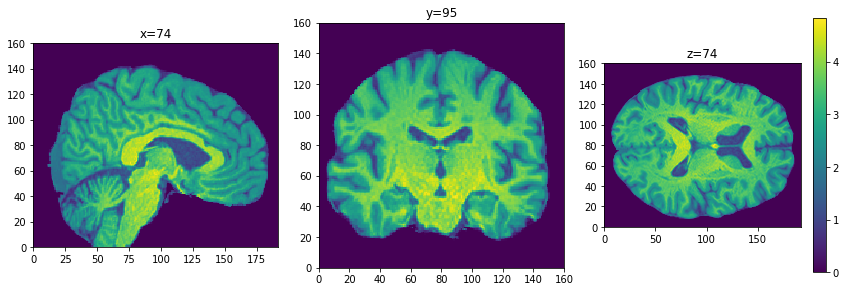

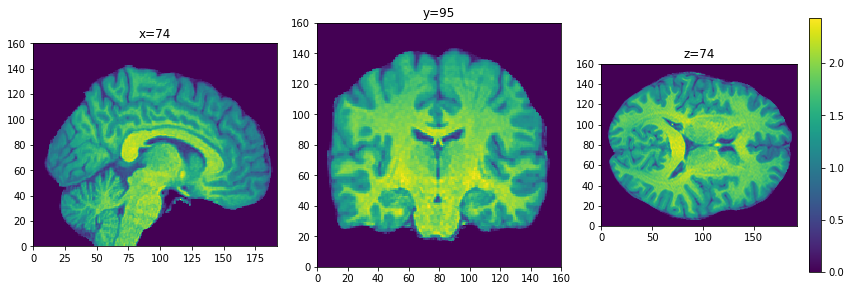

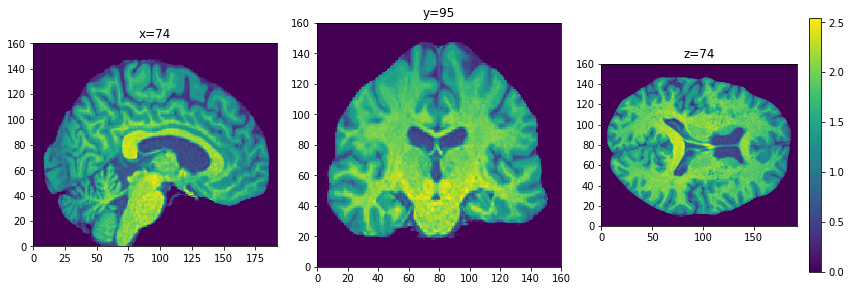

In [7]:
data_recover = np.zeros([160, 192, 160])
data_recover[mask_0] = data_train[100]
dmv.view_data_slices_3(data_recover)

data_recover = np.zeros([160, 192, 160])
data_recover[mask_0] = data_train[1000]
dmv.view_data_slices_3(data_recover)

data_recover = np.zeros([160, 192, 160])
data_recover[mask_0] = data_train[5000]
dmv.view_data_slices_3(data_recover)


data_recover = np.zeros([160, 192, 160])
data_recover[mask_0] = data_test[500]
dmv.view_data_slices_3(data_recover)

### PCA test with 1000 data

In [8]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=300)

In [10]:
data_test = data_all[2000:3000]

In [12]:
pca.fit(data_test)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
tic()
data_new = pca.transform(data_test)
toc()

Elapsed time 8.851399 seconds


8.851398706436157

In [19]:
data_new.shape

(1000, 300)

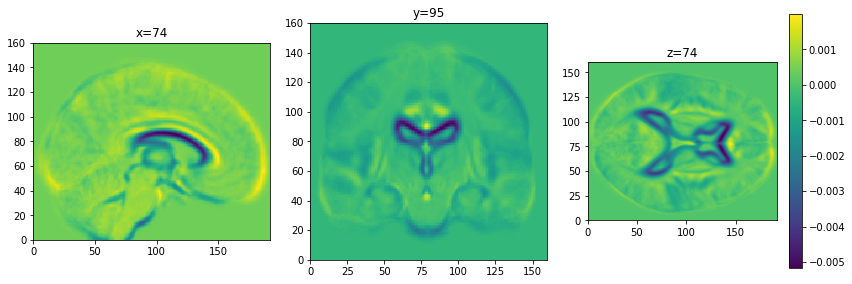

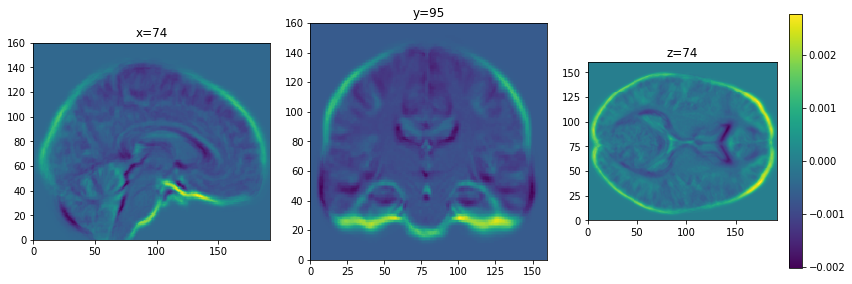

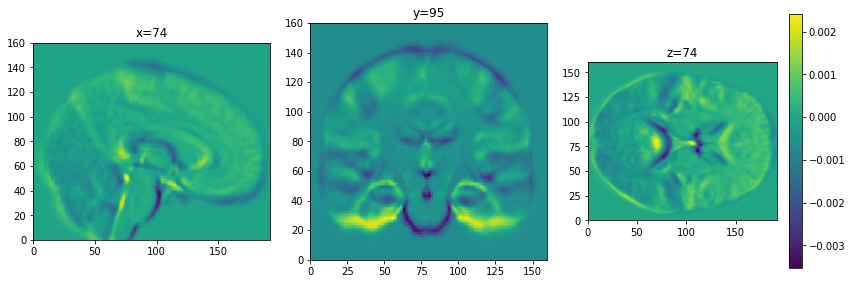

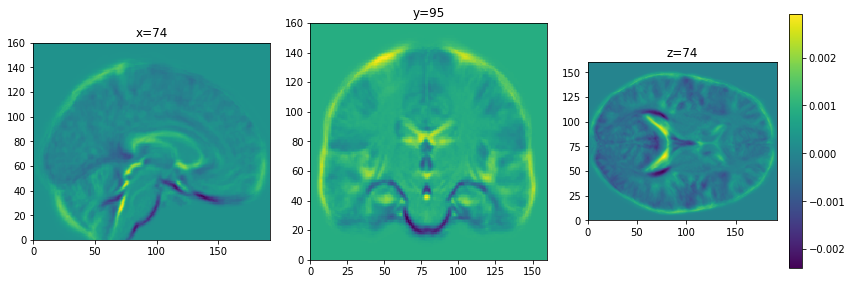

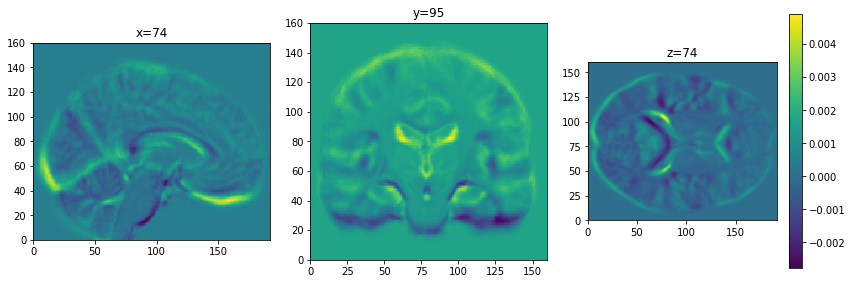

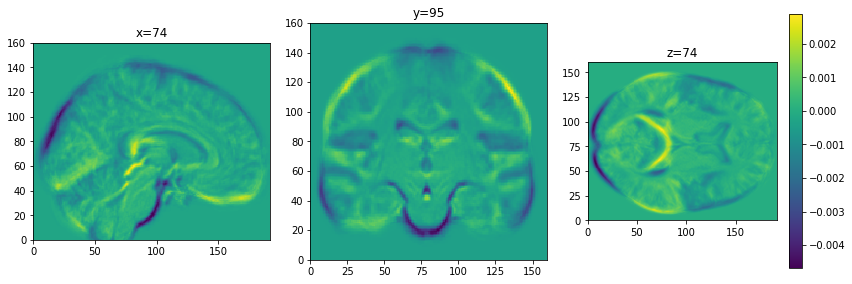

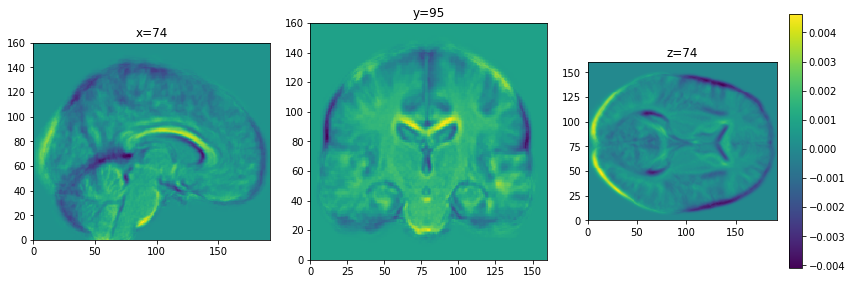

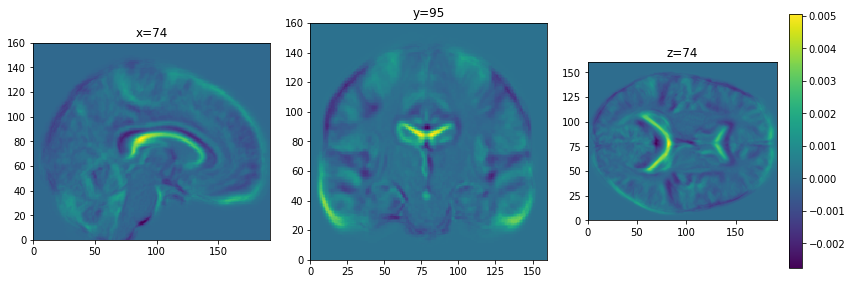

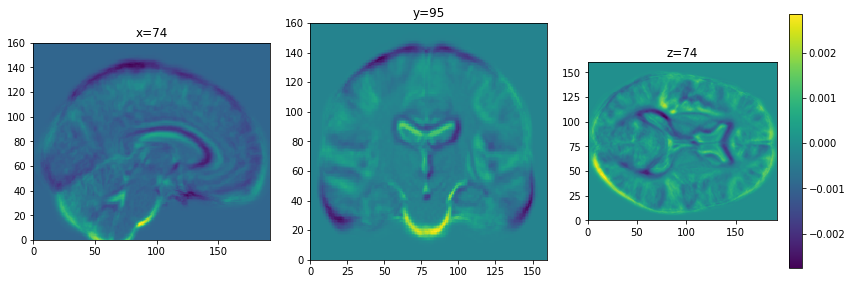

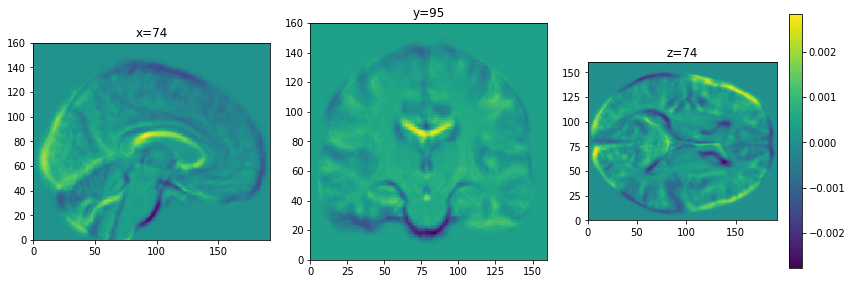

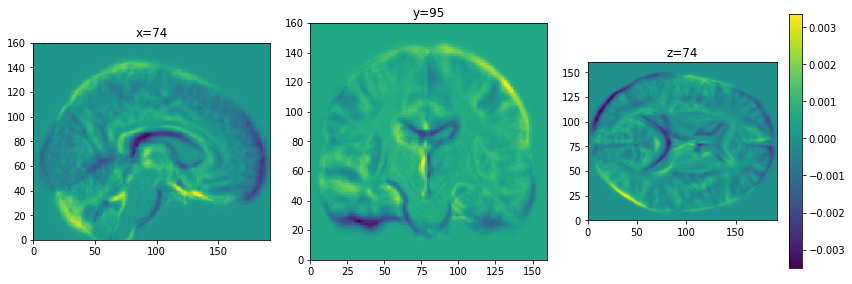

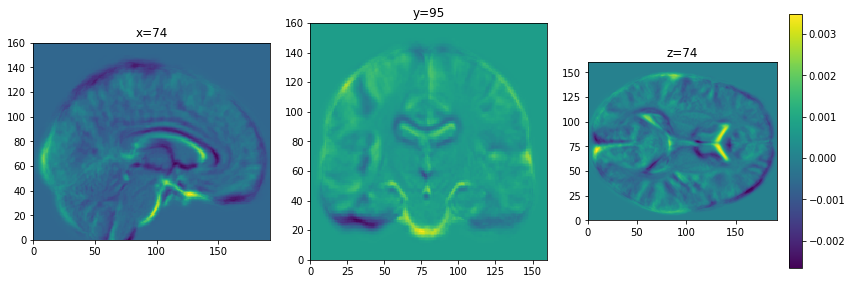

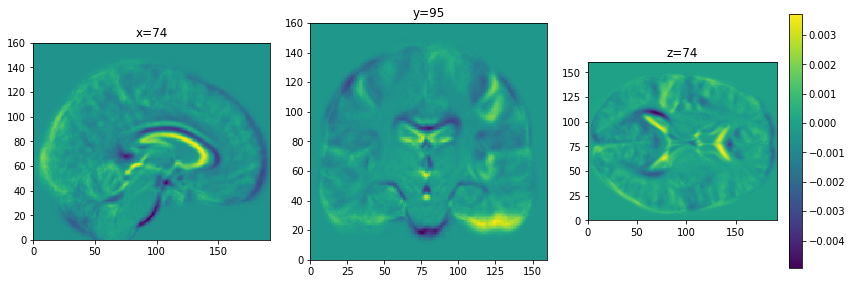

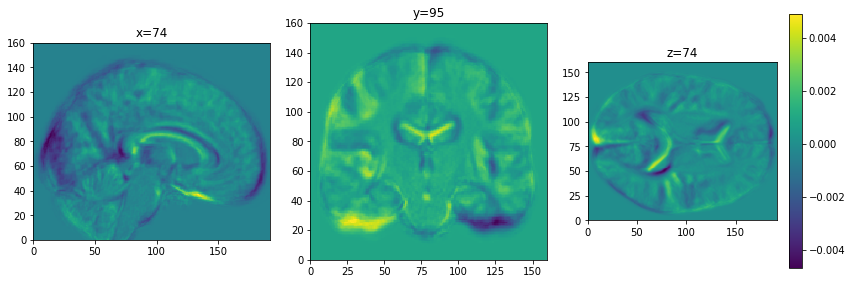

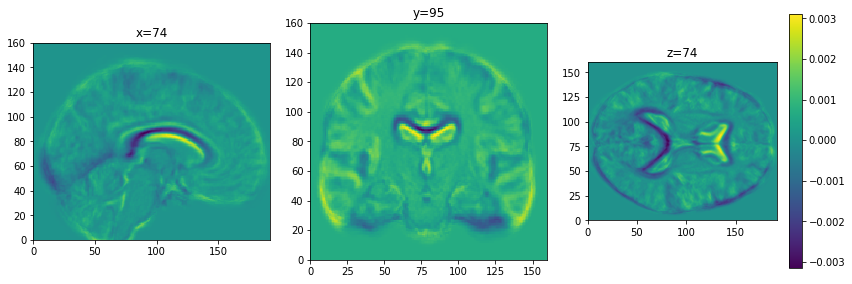

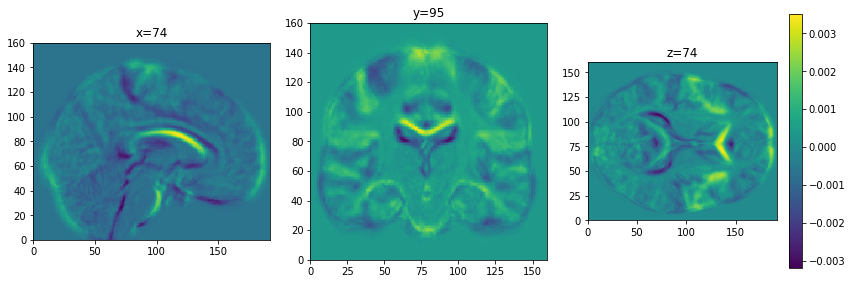

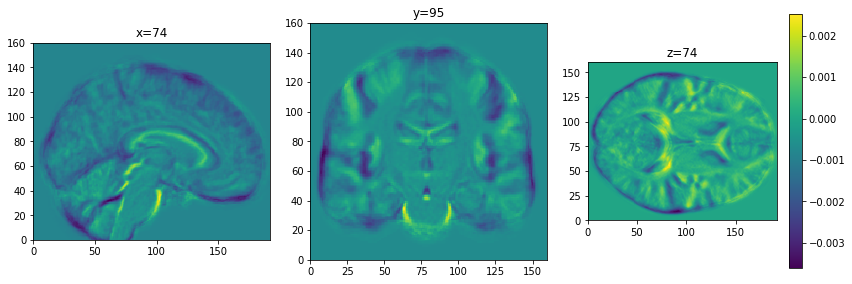

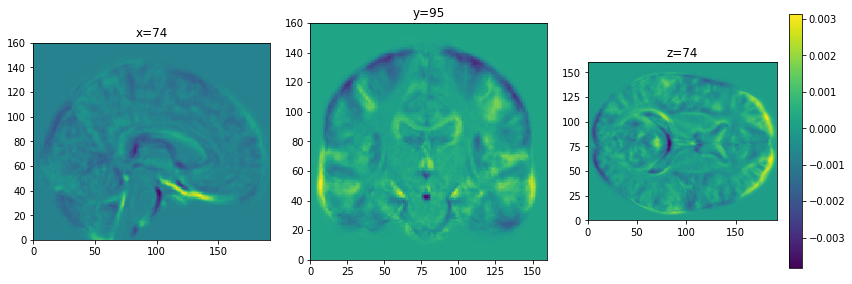

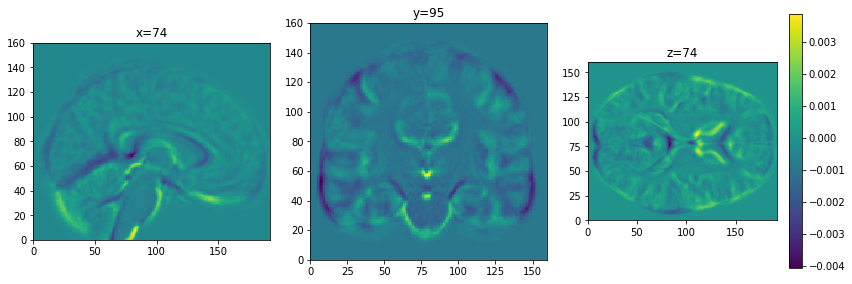

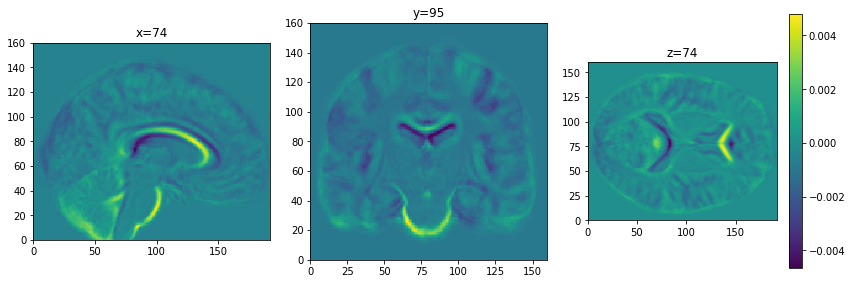

In [25]:
data_recover = np.zeros([160, 192, 160])
for i in range(20):
    data_recover[mask_0] = pca.components_[i]
    dmv.view_data_slices_3(data_recover)

Original


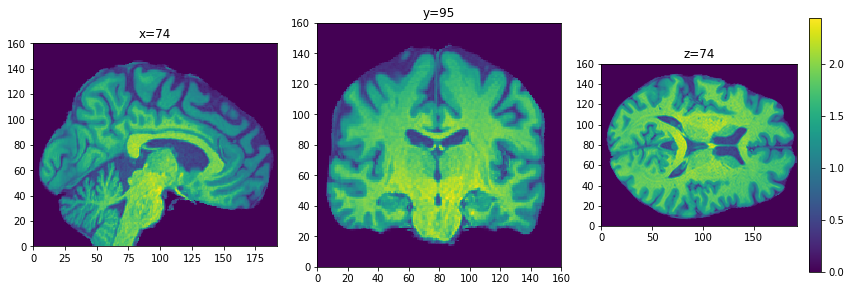

PCA inverse transform


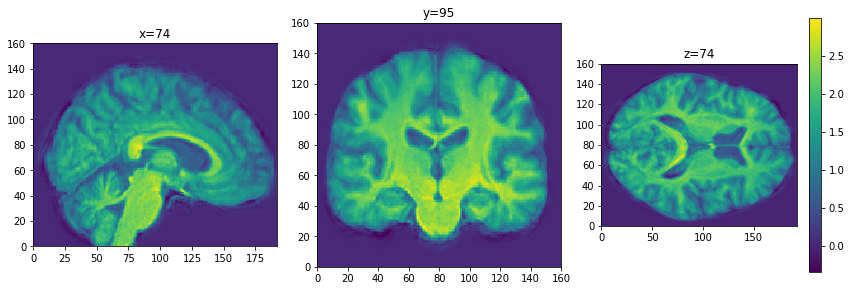

In [27]:
data_1 = data_all[2000]
data_2 = data_new[200]
data_1_new = pca.inverse_transform(data_2)
print('Original')
data_recover[mask_0] = data_1
dmv.view_data_slices_3(data_recover)
print('PCA inverse transform')
data_recover[mask_0] = data_1_new
dmv.view_data_slices_3(data_recover)


### PCA train with 5600 data

In [9]:
data_train.shape

(5600, 2625422)

In [ ]:
# scilearn is slow and memory cosumptuous
#from sklearn import decomposition
#pca = decomposition.PCA(n_components=3000, whiten=True, copy=False)
#data_out = pca.fit_transform(data_train)

In [10]:
tic()
data_mean = data_train.mean(axis=1, keepdims=True)
data_train/=data_mean
toc()

Elapsed time 24.246815 seconds


24.24681544303894

In [13]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3000, whiten=False, copy=False)
tic()
# Use SVD instead
data_out = pca.fit_transform(data_train)
toc();

Elapsed time 2496.565223 seconds


In [14]:
pca.components_.dtype

(3000, 2625422)

In [18]:
data_1.shape

(2625422,)

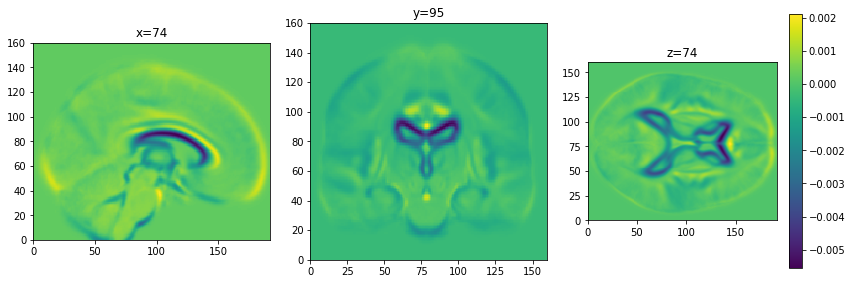

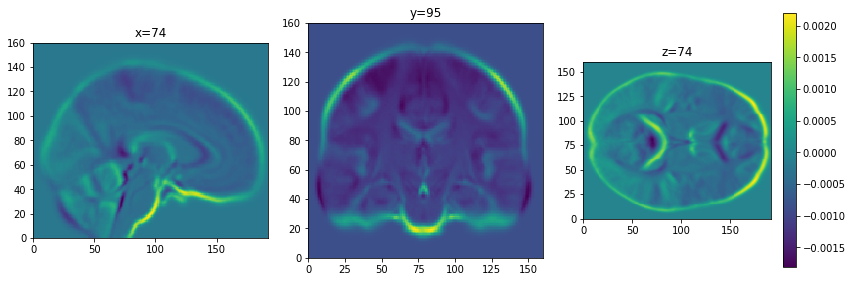

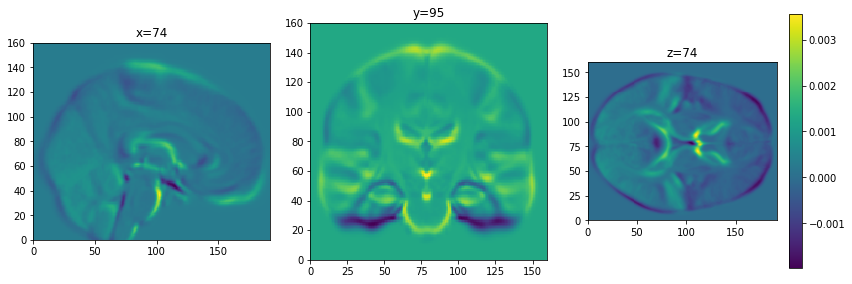

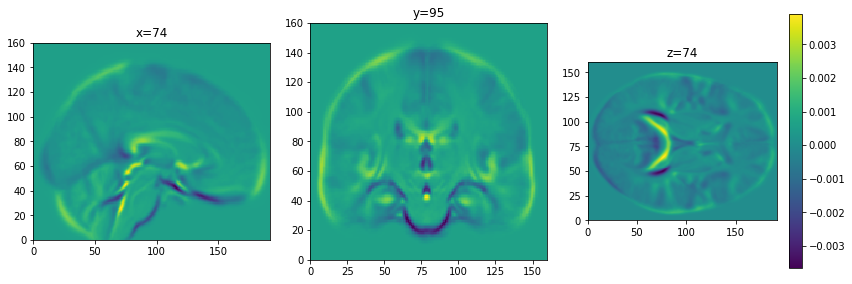

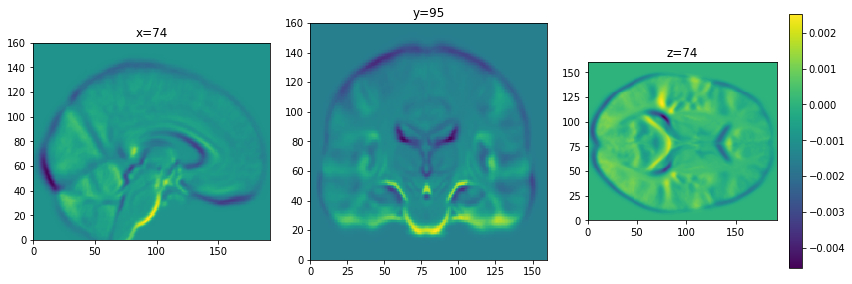

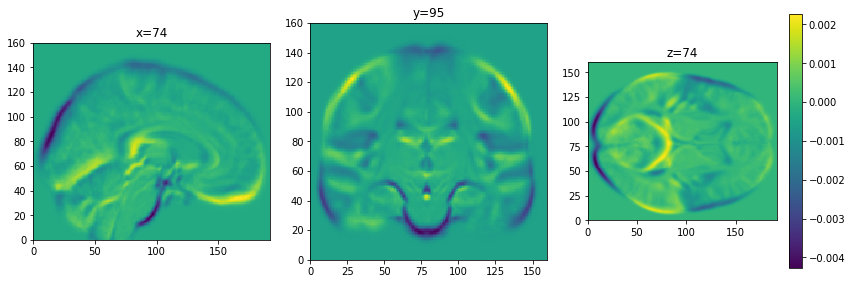

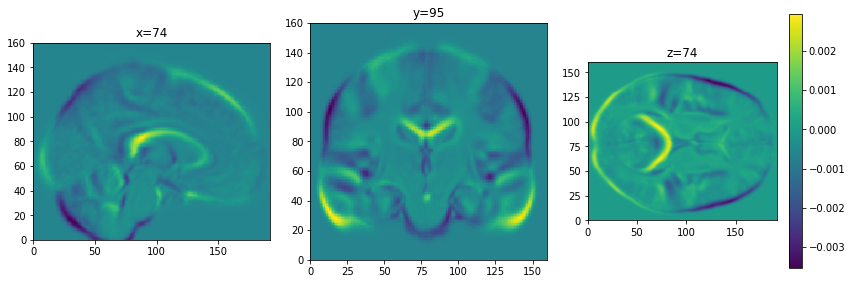

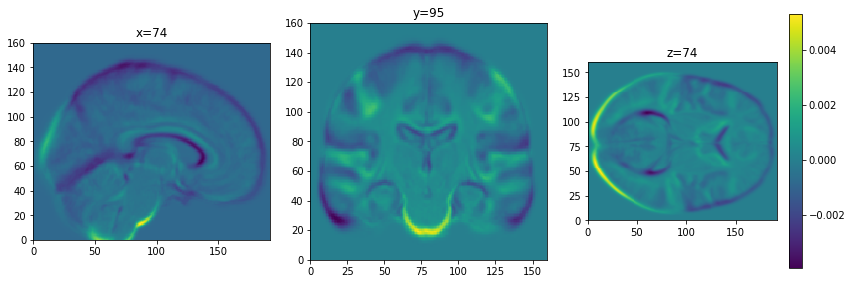

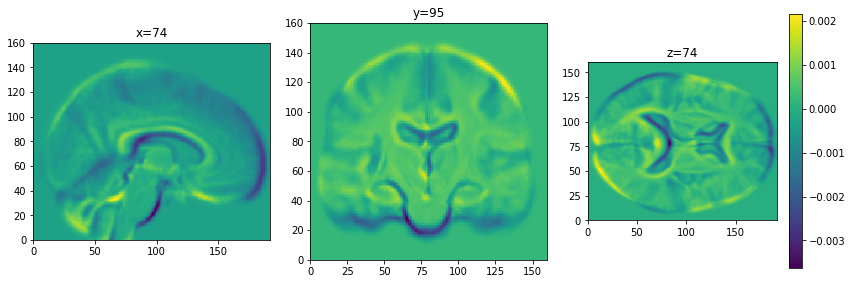

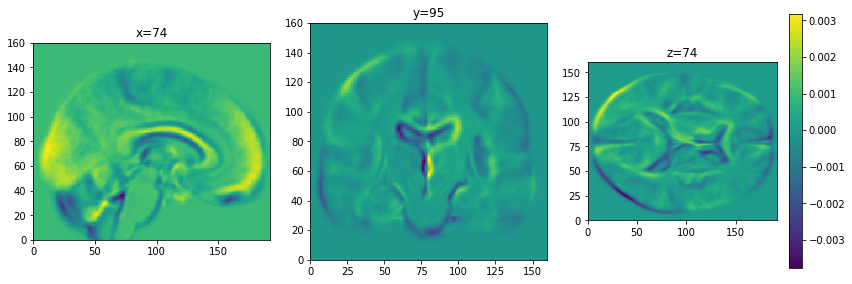

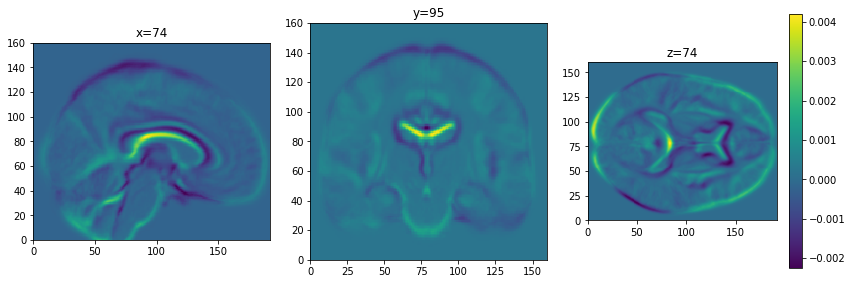

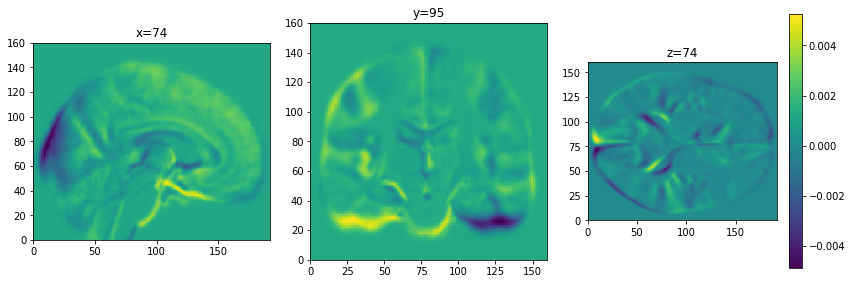

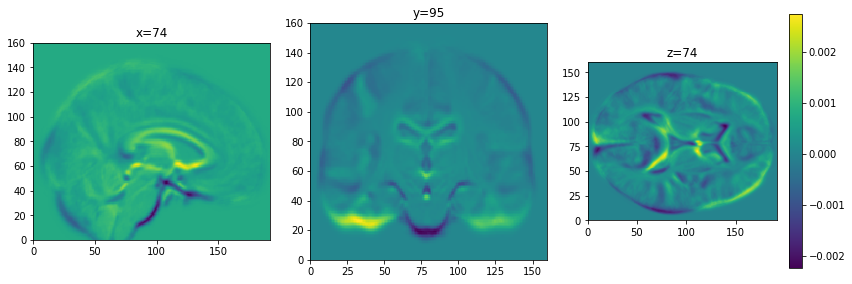

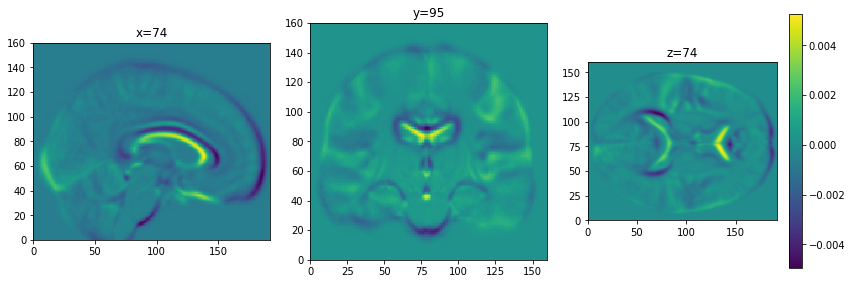

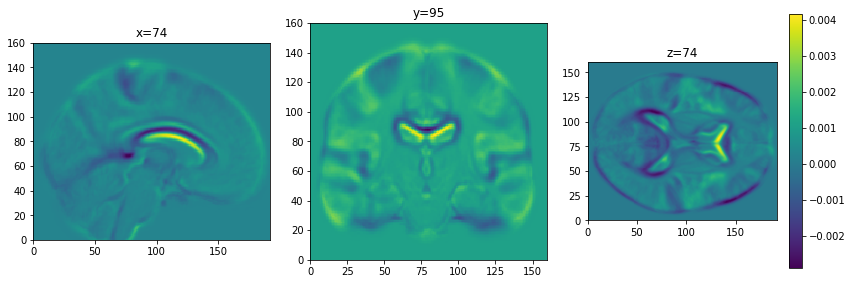

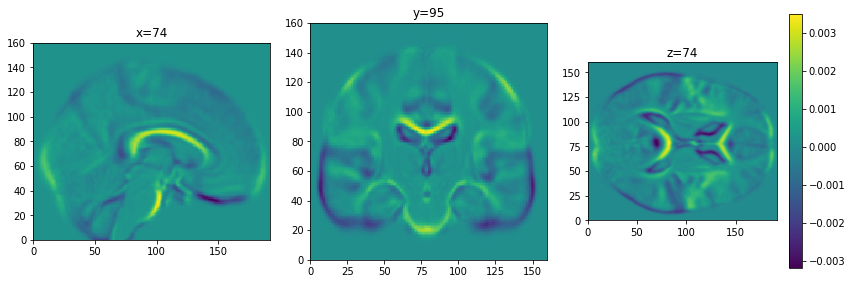

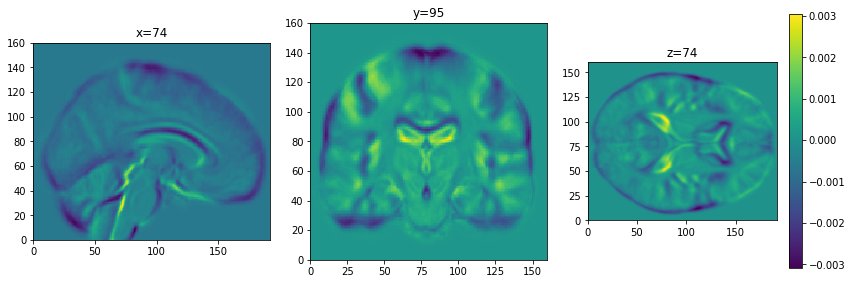

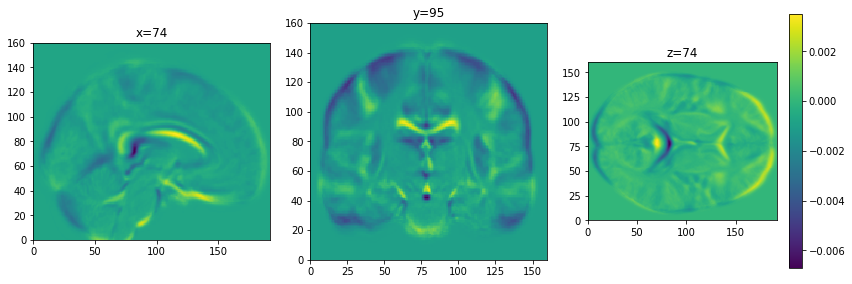

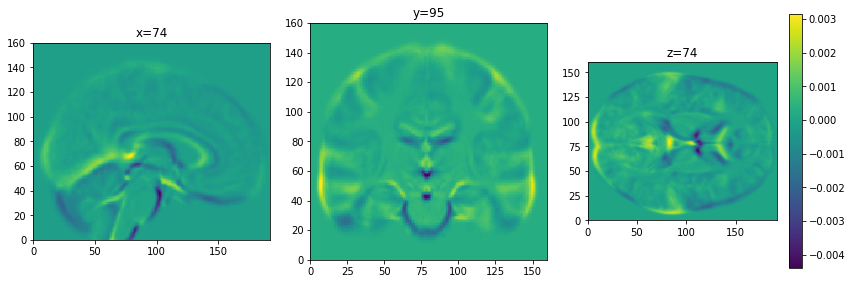

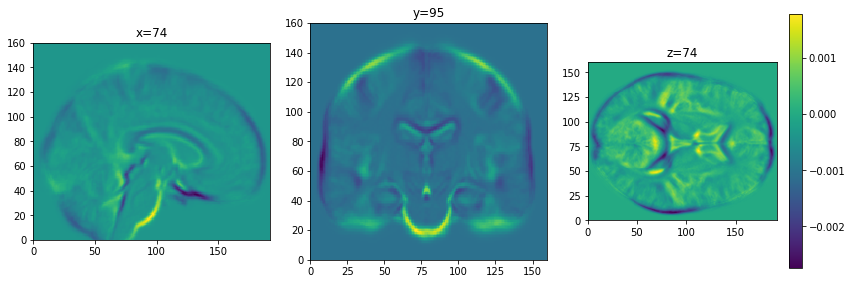

In [19]:
data_recover = np.zeros([160, 192, 160])
for i in range(20):
    data_recover[mask_0] = pca.components_[i]
    dmv.view_data_slices_3(data_recover)

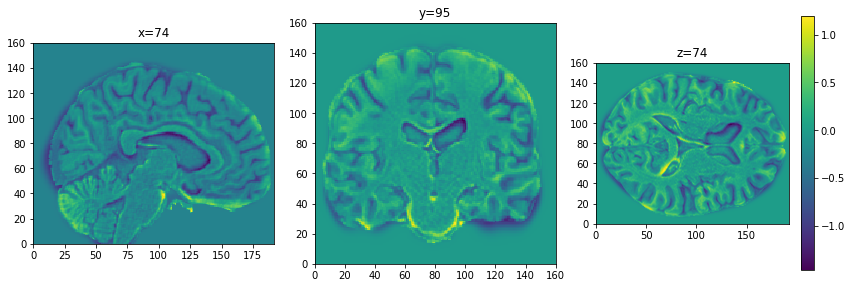

In [21]:
data_1 = data_train[201]
data_recover[mask_0] = data_1
dmv.view_data_slices_3(data_recover)

Original


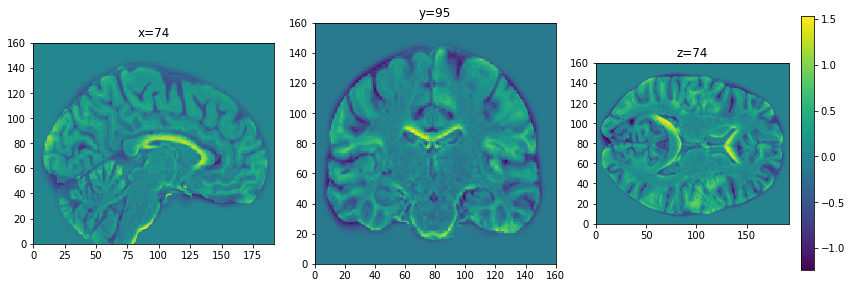

PCA inverse transform


TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

In [22]:
data_1 = data_train[200]
data_2 = data_out[200:201,:]
data_1_new = pca.inverse_transform(data_2)
print('Original')
data_recover[mask_0] = data_1
dmv.view_data_slices_3(data_recover)



PCA inverse transform


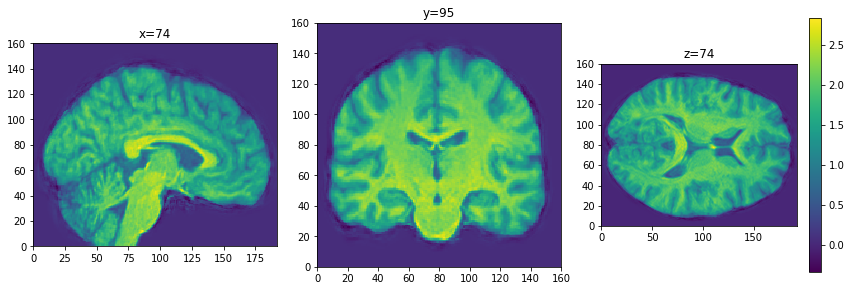

In [24]:
print('PCA inverse transform')
data_recover[mask_0] = data_1_new.reshape(-1)
dmv.view_data_slices_3(data_recover)

## Save PCA result!

In [28]:
pca.components_.shape

(3000, 2625422)

Original


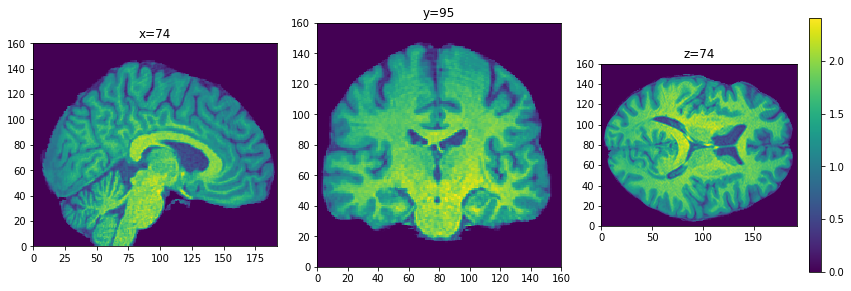

PCA inverse transform


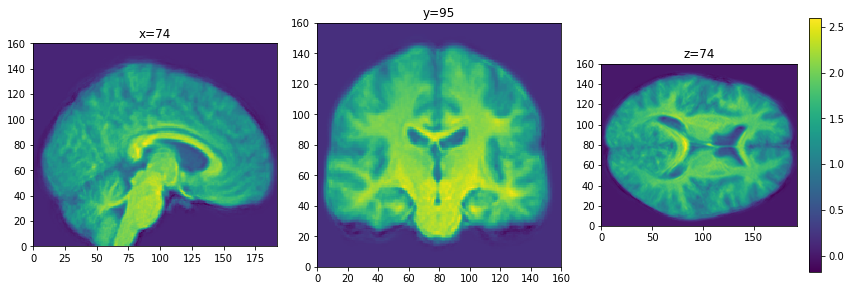

In [32]:
data_1 = data_test[200]-1
data_2 = pca.transform(data_1.reshape([1, -1]))
data_1_new = pca.inverse_transform(data_2)
print('Original')
data_recover[mask_0] = data_1
dmv.view_data_slices_3(data_recover)
print('PCA inverse transform')
data_recover[mask_0] = data_1_new.reshape(-1)
dmv.view_data_slices_3(data_recover)


Original


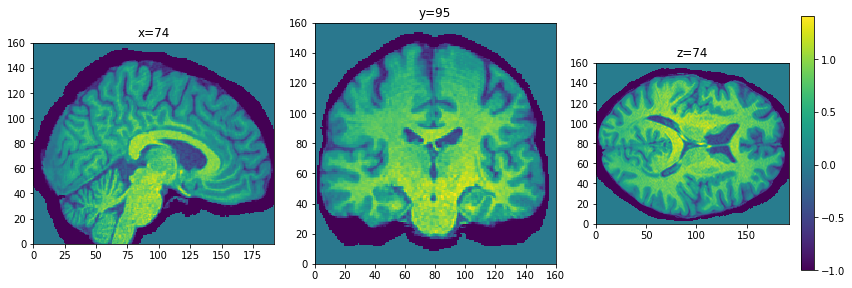

PCA inverse transform


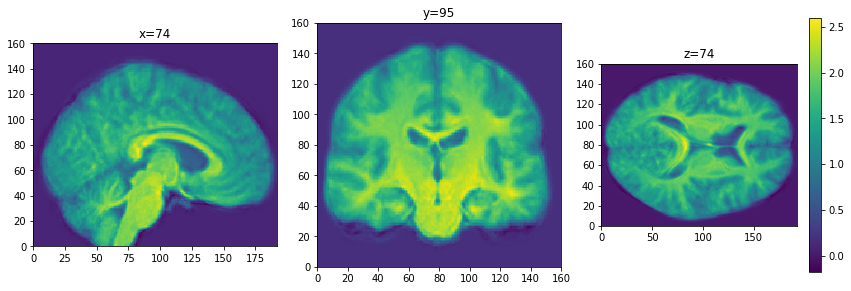

In [34]:
data_1 = data_test[200]/data_test[200].mean()-1
data_2 = pca.transform(data_1.reshape([1, -1]))
data_1_new = pca.inverse_transform(data_2)
print('Original')
data_recover[mask_0] = data_1
dmv.view_data_slices_3(data_recover)
print('PCA inverse transform')
data_recover[mask_0] = data_1_new.reshape(-1)
dmv.view_data_slices_3(data_recover)

In [36]:
pca_components = pca.components_*1.0

In [37]:
pca_save_path_components = '/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1_5600_pca_components.npy'
np.save(pca_save_path_components, pca_components)
pca_save_path_pca = '/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1_5600_pca.p'

    


UnsupportedOperation: write

In [38]:
pca.components_ = None
with open(pca_save_path_pca, 'wb') as f:
    pickle.dump(pca, f)

In [40]:
pca_save_path_result = '/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1_5600_pca_result.npy'
np.save(pca_save_path_result, data_out)

## Linear Model

In [52]:
pca_save_path_result = '/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1_5600_pca_result.npy'
fmrib_info_path = '/well/win-biobank/users/jdo465/age_sex_prediction/fmrib_info_clean.csv'

X = np.load(pca_save_path_result)
fmrib_info = pd.read_csv(fmrib_info_path)
Y = fmrib_info.Age.values[:5600]

X_test = np.load

In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X[:5000], Y[:5000])
reg.score(X, Y)

0.8418466014602703

In [22]:
y2 = reg.predict(X[:5000])
print('Training MAE = %.3f' % np.abs(y2 - Y[:5000]).mean())
y2 = reg.predict(X[5000:])
print('Validation MAE = %.3f' % np.abs(y2 - Y[5000:]).mean())

Training MAE = 1.871
Validation MAE = 4.873



==== component number 10 ====
0.3401893235221629
Training MAE = 4.952, VAR = 36.965
Validation MAE = 4.980, VAR = 36.922

==== component number 30 ====
0.4309254267332827
Training MAE = 4.551, VAR = 31.882
Validation MAE = 4.501, VAR = 30.972

==== component number 60 ====
0.48103489236487607
Training MAE = 4.326, VAR = 29.074
Validation MAE = 4.273, VAR = 28.478

==== component number 100 ====
0.535753417102387
Training MAE = 4.092, VAR = 26.009
Validation MAE = 4.086, VAR = 25.840

==== component number 150 ====
0.5778261004553094
Training MAE = 3.899, VAR = 23.652
Validation MAE = 4.031, VAR = 24.877

==== component number 200 ====
0.6053681363838292
Training MAE = 3.761, VAR = 22.109
Validation MAE = 3.910, VAR = 23.631

==== component number 300 ====
0.6419372278901411
Training MAE = 3.564, VAR = 20.060
Validation MAE = 3.781, VAR = 22.382

==== component number 400 ====
0.6664464845440685
Training MAE = 3.436, VAR = 18.687
Validation MAE = 3.789, VAR = 22.168

==== component num

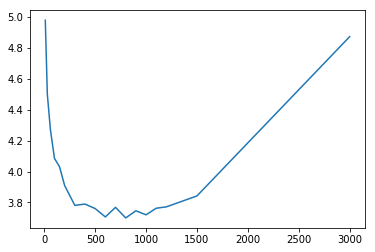

In [59]:
from sklearn.linear_model import LinearRegression

N = 5000
x_temp = np.zeros((0,))
y_temp = np.zeros((0,))
for n_comp in [10, 30, 60, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1500, 3000]:
    print('\n==== component number %d ====' % n_comp)
    reg = LinearRegression().fit(X[:N, :n_comp], Y[:N])
    print(reg.score(X[:N, :n_comp], Y[:N]))
    y2 = reg.predict(X[:N, :n_comp])
    mae = np.abs(y2 - Y[:N]).mean()
    var = np.mean((y2 - Y[:N])**2)
    print('Training MAE = %.3f, VAR = %.3f' % (mae, var))
    y2 = reg.predict(X[N:, :n_comp])
    mae = np.abs(y2 - Y[N:]).mean()
    var = np.mean((y2 - Y[N:])**2)
    print('Validation MAE = %.3f, VAR = %.3f' % (mae, var))
    x_temp = np.concatenate((x_temp, np.array((n_comp, ))))
    y_temp = np.concatenate((y_temp, np.array((mae, ))))
plt.plot(x_temp, y_temp)

## PcaNN

In [83]:
class PcaNN(nn.Module):
    def __init__(self):
        super(PcaNN, self).__init__()
        self.module = nn.Sequential(
            nn.Linear(3000, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),            
            nn.ReLU(),
            nn.Linear(128, 40)
        )
    def forward(self, x):
        x = self.module(x)
        x = F.log_softmax(x, dim=1)
        return x

In [29]:
net = PcaNN()

In [37]:
data = torch.tensor(X, dtype=torch.float32)
label = torch.tensor(Y, dtype=torch.float32)

In [51]:
target,bc = num2vect(label,[42, 82],1,1)

In [52]:
target.shape

(5600, 40)

In [64]:
loss = F.kl_div(out, torch.tensor(target, dtype=torch.float32),  reduction='sum')

In [66]:
loss/5600

tensor(2.2187, grad_fn=<DivBackward0>)

In [80]:
scheduler.state_dict()

{'step_size': 200, 'gamma': 0.3, 'base_lrs': [0.003], 'last_epoch': 999}

In [81]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.003
    lr: 2.4299999999999998e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 0.001
)


In [93]:
class scalar_record(dict):
    def __init__(self):
        super(scalar_record).__init__()
    def add(self, key, value):
        if not key in self.keys():
            self[key] = np.zeros(0)
        self[key] = np.concatenate((self[key], np.array((value,))))
    def plot(self):
        for key in self.keys():
            plt.plot(self[key],label=key)
        plt.grid(True)
        plt.legend()

In [85]:
N = 5000
N_epoch = 500
data = torch.tensor(X[:N], dtype=torch.float32)
label = torch.tensor(Y[:N], dtype=torch.float32)

data_test = torch.tensor(X[N:], dtype=torch.float32)
label_test = torch.tensor(Y[N:], dtype=torch.float32)

target, bc = num2vect(label, [42, 82], 1, 1)
target = torch.tensor(target, dtype=torch.float32)

In [105]:
model = PcaNN()

learning_rate = 0.003
momentum = 0.3
weight_decay = 0.001

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum,
                      weight_decay=weight_decay)
optimizer.zero_grad()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.3) 

train_log = scalar_record()

for i in range(N_epoch):
    out = model(data)
    loss = F.kl_div(out, target, reduction='sum')/N
    prob = np.exp(out.detach().numpy())
    pred_age = np.dot(prob,bc)
    d = pred_age - label
    mae = np.abs(d).mean()
    loss.backward()
    with torch.no_grad():
        out = model(data_test)
        prob = np.exp(out.numpy())
        pred_age = np.dot(prob,bc)
        d_test = pred_age - label_test
        mae_test = np.abs(d_test).mean()
    train_log.add('mae', mae)
    train_log.add('mae_test', mae_test)
    optimizer.step()
    scheduler.step()
    if (i+1)%1==0:
        print('i=%4d, loss=%.3f, mae=%.3f, mae_test=%.3f' % (i, loss, mae, mae_test))

i=   0, loss=2.244, mae=6.284, mae_test=6.281
i=   1, loss=2.243, mae=6.283, mae_test=6.281
i=   2, loss=2.241, mae=6.283, mae_test=6.281
i=   3, loss=2.237, mae=6.283, mae_test=6.280
i=   4, loss=2.232, mae=6.283, mae_test=6.280
i=   5, loss=2.226, mae=6.282, mae_test=6.280
i=   6, loss=2.219, mae=6.281, mae_test=6.279
i=   7, loss=2.211, mae=6.280, mae_test=6.278
i=   8, loss=2.202, mae=6.278, mae_test=6.276
i=   9, loss=2.192, mae=6.276, mae_test=6.274
i=  10, loss=2.181, mae=6.273, mae_test=6.272
i=  11, loss=2.170, mae=6.269, mae_test=6.269
i=  12, loss=2.158, mae=6.264, mae_test=6.265
i=  13, loss=2.146, mae=6.259, mae_test=6.260
i=  14, loss=2.133, mae=6.252, mae_test=6.255
i=  15, loss=2.119, mae=6.244, mae_test=6.249
i=  16, loss=2.104, mae=6.236, mae_test=6.242
i=  17, loss=2.089, mae=6.225, mae_test=6.234
i=  18, loss=2.073, mae=6.214, mae_test=6.225
i=  19, loss=2.058, mae=6.200, mae_test=6.215
i=  20, loss=2.043, mae=6.185, mae_test=6.204
i=  21, loss=2.030, mae=6.169, mae

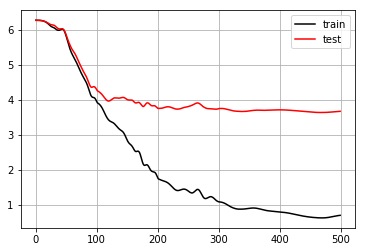

In [108]:
plt.plot(train_log['mae'],'k',label='train')
plt.plot(train_log['mae_test'],'r', label='test')
plt.grid(True)
plt.legend()

In [85]:
N = 5000

data = torch.tensor(X[:N], dtype=torch.float32)
label = torch.tensor(Y[:N], dtype=torch.float32)

data_test = torch.tensor(X[N:], dtype=torch.float32)
label_test = torch.tensor(Y[N:], dtype=torch.float32)

target, bc = num2vect(label, [42, 82], 1, 1)
target = torch.tensor(target, dtype=torch.float32)

In [115]:
N_epoch = 1000

model = PcaNN()

learning_rate = 0.003
momentum = 0.3
weight_decay = 0.1

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum,
                      weight_decay=weight_decay)
optimizer.zero_grad()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.3) 

train_log = scalar_record()

for i in range(N_epoch):
    out = model(data)
    loss = F.kl_div(out, target, reduction='sum')/N
    prob = np.exp(out.detach().numpy())
    pred_age = np.dot(prob,bc)
    d = pred_age - label
    mae = np.abs(d).mean()
    loss.backward()
    with torch.no_grad():
        out = model(data_test)
        prob = np.exp(out.numpy())
        pred_age = np.dot(prob,bc)
        d_test = pred_age - label_test
        mae_test = np.abs(d_test).mean()
    train_log.add('mae', mae)
    train_log.add('mae_test', mae_test)
    optimizer.step()
    scheduler.step()
    if (i+1)%1==0:
        print('i=%4d, loss=%.3f, mae=%.3f, mae_test=%.3f' % (i, loss, mae, mae_test))

i=   0, loss=2.242, mae=6.375, mae_test=6.352
i=   1, loss=2.240, mae=6.374, mae_test=6.351
i=   2, loss=2.238, mae=6.373, mae_test=6.351
i=   3, loss=2.234, mae=6.372, mae_test=6.350
i=   4, loss=2.228, mae=6.370, mae_test=6.348
i=   5, loss=2.222, mae=6.368, mae_test=6.346
i=   6, loss=2.214, mae=6.365, mae_test=6.343
i=   7, loss=2.205, mae=6.362, mae_test=6.340
i=   8, loss=2.196, mae=6.359, mae_test=6.336
i=   9, loss=2.187, mae=6.355, mae_test=6.333
i=  10, loss=2.177, mae=6.351, mae_test=6.329
i=  11, loss=2.167, mae=6.347, mae_test=6.325
i=  12, loss=2.157, mae=6.343, mae_test=6.321
i=  13, loss=2.146, mae=6.339, mae_test=6.317
i=  14, loss=2.135, mae=6.334, mae_test=6.312
i=  15, loss=2.124, mae=6.328, mae_test=6.307
i=  16, loss=2.111, mae=6.320, mae_test=6.301
i=  17, loss=2.098, mae=6.312, mae_test=6.295
i=  18, loss=2.085, mae=6.301, mae_test=6.286
i=  19, loss=2.070, mae=6.289, mae_test=6.277
i=  20, loss=2.056, mae=6.274, mae_test=6.266
i=  21, loss=2.041, mae=6.257, mae

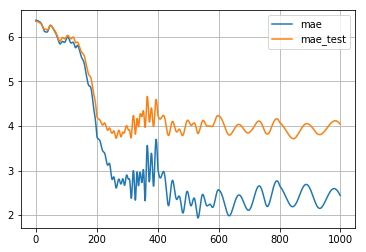

In [120]:
train_log.plt(1,2)

i=   0, loss=2.215, mae=6.326, mae_test=6.320
i=   1, loss=2.214, mae=6.326, mae_test=6.320
i=   2, loss=2.212, mae=6.325, mae_test=6.319
i=   3, loss=2.209, mae=6.323, mae_test=6.318
i=   4, loss=2.205, mae=6.321, mae_test=6.316
i=   5, loss=2.199, mae=6.319, mae_test=6.314
i=   6, loss=2.192, mae=6.316, mae_test=6.311
i=   7, loss=2.185, mae=6.312, mae_test=6.308
i=   8, loss=2.175, mae=6.308, mae_test=6.305
i=   9, loss=2.165, mae=6.304, mae_test=6.301
i=  10, loss=2.154, mae=6.300, mae_test=6.297
i=  11, loss=2.141, mae=6.295, mae_test=6.293
i=  12, loss=2.127, mae=6.290, mae_test=6.288
i=  13, loss=2.112, mae=6.283, mae_test=6.282
i=  14, loss=2.095, mae=6.275, mae_test=6.275
i=  15, loss=2.077, mae=6.266, mae_test=6.267
i=  16, loss=2.058, mae=6.255, mae_test=6.257
i=  17, loss=2.039, mae=6.241, mae_test=6.245
i=  18, loss=2.019, mae=6.224, mae_test=6.231
i=  19, loss=2.000, mae=6.205, mae_test=6.216
i=  20, loss=1.984, mae=6.184, mae_test=6.199
i=  21, loss=1.972, mae=6.163, mae

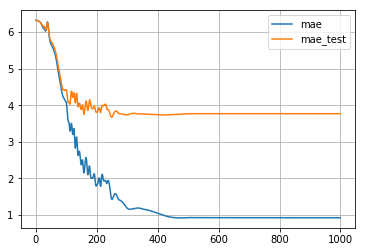

In [121]:
N_epoch = 1000

model = PcaNN()

learning_rate = 0.003
momentum = 0.3
weight_decay = 0.1

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum,
                      weight_decay=weight_decay)
optimizer.zero_grad()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.3) 

train_log = scalar_record()

for i in range(N_epoch):
    out = model(data)
    loss = F.kl_div(out, target, reduction='sum')/N
    prob = np.exp(out.detach().numpy())
    pred_age = np.dot(prob,bc)
    d = pred_age - label
    mae = np.abs(d).mean()
    loss.backward()
    with torch.no_grad():
        out = model(data_test)
        prob = np.exp(out.numpy())
        pred_age = np.dot(prob,bc)
        d_test = pred_age - label_test
        mae_test = np.abs(d_test).mean()
    train_log.add('mae', mae)
    train_log.add('mae_test', mae_test)
    optimizer.step()
    scheduler.step()
    if (i+1)%1==0:
        print('i=%4d, loss=%.3f, mae=%.3f, mae_test=%.3f' % (i, loss, mae, mae_test))

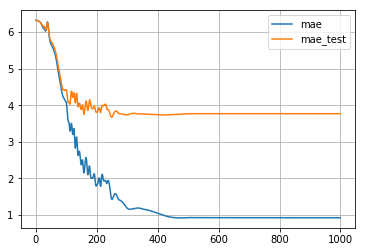

In [122]:
train_log.plot()

In [137]:
class PcaNN_Dropout(nn.Module):
    def __init__(self):
        super(PcaNN_Dropout, self).__init__()
        self.module = nn.Sequential(
            nn.Linear(3000, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 128),            
            nn.ReLU(),            
            nn.Linear(128, 40)
        )
    def forward(self, x):
        x = self.module(x)
        x = F.log_softmax(x, dim=1)
        return x

N_epoch = 1000

model = PcaNN_Dropout()

learning_rate = 0.003
momentum = 0.3
weight_decay = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum,
                      weight_decay=weight_decay)
optimizer.zero_grad()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.3) 

train_log = scalar_record()

for i in range(N_epoch):
    model.train()
    out = model(data)
    loss = F.kl_div(out, target, reduction='sum')/N
    prob = np.exp(out.detach().numpy())
    pred_age = np.dot(prob,bc)
    d = pred_age - label
    mae = np.abs(d).mean()
    loss.backward()
    with torch.no_grad():
        model.eval()
        out = model(data_test)
        prob = np.exp(out.numpy())
        pred_age = np.dot(prob,bc)
        d_test = pred_age - label_test
        mae_test = np.abs(d_test).mean()
    train_log.add('mae', mae)
    train_log.add('mae_test', mae_test)
    optimizer.step()
    scheduler.step()
    if (i+1)%1==0:
        print('i=%4d, loss=%.3f, mae=%.3f, mae_test=%.3f' % (i, loss, mae, mae_test))

i=   0, loss=2.260, mae=6.327, mae_test=6.336
i=   1, loss=2.259, mae=6.319, mae_test=6.335
i=   2, loss=2.255, mae=6.325, mae_test=6.335
i=   3, loss=2.252, mae=6.329, mae_test=6.334
i=   4, loss=2.248, mae=6.317, mae_test=6.333
i=   5, loss=2.241, mae=6.328, mae_test=6.332
i=   6, loss=2.231, mae=6.325, mae_test=6.331
i=   7, loss=2.222, mae=6.327, mae_test=6.329
i=   8, loss=2.213, mae=6.314, mae_test=6.326
i=   9, loss=2.203, mae=6.309, mae_test=6.324
i=  10, loss=2.193, mae=6.313, mae_test=6.321
i=  11, loss=2.181, mae=6.316, mae_test=6.317
i=  12, loss=2.169, mae=6.314, mae_test=6.314
i=  13, loss=2.156, mae=6.304, mae_test=6.309
i=  14, loss=2.144, mae=6.296, mae_test=6.305
i=  15, loss=2.130, mae=6.294, mae_test=6.299
i=  16, loss=2.117, mae=6.291, mae_test=6.294
i=  17, loss=2.103, mae=6.277, mae_test=6.287
i=  18, loss=2.088, mae=6.272, mae_test=6.280
i=  19, loss=2.073, mae=6.257, mae_test=6.272
i=  20, loss=2.062, mae=6.257, mae_test=6.264
i=  21, loss=2.045, mae=6.233, mae

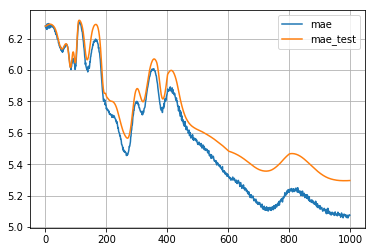

In [136]:
train_log.plot()

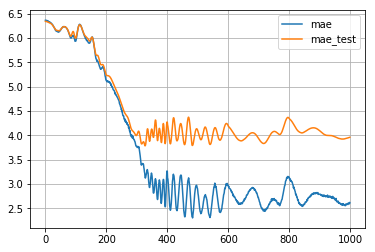

In [129]:
train_log.plot()

## smaller number of parameters

i=   0, loss=2.240, mae=6.333, mae_test=6.315
i=   1, loss=2.240, mae=6.333, mae_test=6.315
i=   2, loss=2.239, mae=6.332, mae_test=6.315
i=   3, loss=2.237, mae=6.332, mae_test=6.315
i=   4, loss=2.234, mae=6.332, mae_test=6.314
i=   5, loss=2.230, mae=6.331, mae_test=6.314
i=   6, loss=2.226, mae=6.331, mae_test=6.313
i=   7, loss=2.222, mae=6.330, mae_test=6.312
i=   8, loss=2.217, mae=6.329, mae_test=6.312
i=   9, loss=2.211, mae=6.328, mae_test=6.311
i=  10, loss=2.206, mae=6.327, mae_test=6.310
i=  11, loss=2.200, mae=6.326, mae_test=6.310
i=  12, loss=2.193, mae=6.325, mae_test=6.309
i=  13, loss=2.187, mae=6.324, mae_test=6.309
i=  14, loss=2.180, mae=6.323, mae_test=6.308
i=  15, loss=2.174, mae=6.323, mae_test=6.307
i=  16, loss=2.167, mae=6.322, mae_test=6.307
i=  17, loss=2.159, mae=6.321, mae_test=6.306
i=  18, loss=2.152, mae=6.320, mae_test=6.306
i=  19, loss=2.144, mae=6.319, mae_test=6.306
i=  20, loss=2.136, mae=6.318, mae_test=6.305
i=  21, loss=2.128, mae=6.316, mae

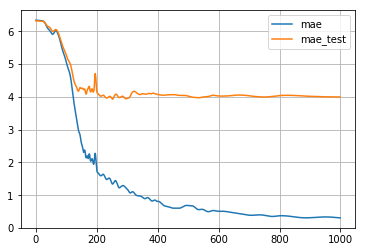

In [134]:
class PcaNN(nn.Module):
    def __init__(self):
        super(PcaNN, self).__init__()
        self.module = nn.Sequential(
            nn.Linear(3000, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),            
            nn.ReLU(),
            nn.Linear(64, 40)
        )
    def forward(self, x):
        x = self.module(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    
N_epoch = 1000

model = PcaNN()

learning_rate = 0.003
momentum = 0.3
weight_decay = 0.001

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum,
                      weight_decay=weight_decay)
optimizer.zero_grad()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.3) 

train_log = scalar_record()

for i in range(N_epoch):
    model.train()
    out = model(data)
    loss = F.kl_div(out, target, reduction='sum')/N
    prob = np.exp(out.detach().numpy())
    pred_age = np.dot(prob,bc)
    d = pred_age - label
    mae = np.abs(d).mean()
    loss.backward()
    with torch.no_grad():
        model.eval()
        out = model(data_test)
        prob = np.exp(out.numpy())
        pred_age = np.dot(prob,bc)
        d_test = pred_age - label_test
        mae_test = np.abs(d_test).mean()
    train_log.add('mae', mae)
    train_log.add('mae_test', mae_test)
    optimizer.step()
    scheduler.step()
    if (i+1)%1==0:
        print('i=%4d, loss=%.3f, mae=%.3f, mae_test=%.3f' % (i, loss, mae, mae_test))
train_log.plot()

# Try ABCD dataset

In [1]:
import os

import torch.nn as nn
import torch.nn.functional as F
import numpy as np


import multiprocessing as mp
from my_models.age_sex_pred import *
from utils.result_analysis import *
import pickle
import dm_model.dm_models as dmm
import dm_model.dm_utils as dmu
import dm_model.dm_dataset as dmd
import dm_model.dm_loss as dml
import dm_model.dm_train as dmt
import dm_model.dm_visualisation as dmv
import importlib
importlib.reload(dmm)
importlib.reload(dmd)
import pickle
import collections
import re

import nibabel
from sklearn.cluster import KMeans

import time

/users/win-biobank/jdo465/anaconda3/envs/pytorch_1_0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Age-Sex Prediction Module imported.2019-03-12 17:54:12
Config I/O Module imported.2019-03-12 17:54:12


In [15]:
import os

import torch.nn as nn
import torch.nn.functional as F
import numpy as np


import multiprocessing as mp
from my_models.age_sex_pred import *
from utils.result_analysis import *
import pickle
import dm_model.dm_models as dmm
import dm_model.dm_utils as dmu
import dm_model.dm_dataset as dmd
import dm_model.dm_loss as dml
import dm_model.dm_train as dmt
import dm_model.dm_visualisation as dmv
import importlib
importlib.reload(dmm)
importlib.reload(dmd)
import pickle
import collections
import re

import nibabel
from sklearn.cluster import KMeans

import time


def tic():
    global t_tic_tag
    t_tic_tag = time.time()
def toc():
    global t_tic_tag
    dt = time.time() - t_tic_tag
    print('Elapsed time %f seconds'%dt)
    return dt


config_path = '/well/win-biobank/users/jdo465/age_sex_prediction/abcd_20190124_01/config.ini'
config = dmu.Configurations(config_path)
subject = dmd.ABCDSubjects(config)
fmrib_info = pd.read_csv(subject.fmrib_info_path)

N = fmrib_info.shape[0]

log_interval = 10

N_init = 2000

total_count = np.prod((160, 192, 160))
x_crop = int((182-160)/2)
y_crop = int((218-192)/2)
z_crop = int((182-160)/2)

print('==== Build Initial Data Matrix to Calculate Non-zero Mask ====')
data_init = np.zeros((N_init, 160, 192, 160), dtype=np.float32)
tic()
for i in range(N_init):
    subject = dmd.ABCDSubjects(index=i, config=config)
    data = nibabel.load(subject.selected_image_path).get_fdata(dtype=np.float32)[x_crop:-x_crop, y_crop:-y_crop, z_crop:-z_crop]
    data_init[i] = data/data.mean()    
    if (i+1)%log_interval==0:      
        zero_count = np.sum(np.sum(data_init, axis=0)==0)    
        print('Loaded %d: Zeros %d, All %d' % (i+1, zero_count, total_count))
        dt = toc()
        tic()
        print('Time left %.3fs' % (dt*(N_init-i-1)/log_interval))
        
mask_0 = np.sum(data_init, axis=0)!=0
n_non_zero = np.sum(mask_0)
mask = (mask_0.reshape([1, 160, 192, 160]).repeat(N_init, axis=0))

In [23]:
print('==== Load the rest of data ====')

data_all = np.zeros((N, n_non_zero), dtype=np.float32)
data_all[:N_init] = data_init[mask].reshape([N_init, -1])

tic()
for i in range(N_init, N): 
    subject = dmd.ABCDSubjects(index=i, config=config)
    data = nibabel.load(subject.selected_image_path).get_fdata(dtype=np.float32)[x_crop:-x_crop, y_crop:-y_crop, z_crop:-z_crop]
    data /= data.mean()
    data_all[i] = data[mask_0].reshape(-1)
    if (i+1)%log_interval==0:
        print('Loaded %d' % (i+1, ))
        dt = toc()
        tic()
        print('Time left %.3fs' % (dt*(N-i-1)/log_interval))

print('==== Save data ====')
save_path = '/well/win-biobank/users/jdo465/abcd_proj/all_subject_T1.npy'
save_path_mask = '/well/win-biobank/users/jdo465/abcd_proj/all_subject_T1_nonzero_mask.npy'
with open(save_path, 'wb') as f:
    np.save(f, data_all)
with open(save_path_mask, 'wb') as f:
    np.save(f, mask_0)
print('Done. Saved at %s' % save_path)

==== Load the rest of data ====
Loaded 2010
Elapsed time 2.963621 seconds
Time left 413.722s
Loaded 2020
Elapsed time 2.745700 seconds
Time left 380.554s
Loaded 2030
Elapsed time 2.625433 seconds
Time left 361.260s
Loaded 2040
Elapsed time 2.482545 seconds
Time left 339.116s
Loaded 2050
Elapsed time 2.459240 seconds
Time left 333.473s
Loaded 2060
Elapsed time 2.398441 seconds
Time left 322.830s
Loaded 2070
Elapsed time 2.434555 seconds
Time left 325.257s
Loaded 2080
Elapsed time 2.443012 seconds
Time left 323.943s
Loaded 2090
Elapsed time 2.622041 seconds
Time left 345.061s
Loaded 2100
Elapsed time 2.552991 seconds
Time left 333.421s
Loaded 2110
Elapsed time 2.820022 seconds
Time left 365.475s
Loaded 2120
Elapsed time 2.557018 seconds
Time left 328.832s
Loaded 2130
Elapsed time 2.668812 seconds
Time left 340.540s
Loaded 2140
Elapsed time 2.627908 seconds
Time left 332.693s
Loaded 2150
Elapsed time 2.648322 seconds
Time left 332.629s
Loaded 2160
Elapsed time 2.750997 seconds
Time left 3

In [22]:
data_all[i] = data[mask_0].reshape(-1)

In [ ]:
tic()
data_all = np.load('/well/win-biobank/users/jdo465/abcd_proj/all_subject_T1.npy')
toc();
mask_0 = np.load('/well/win-biobank/users/jdo465/age_sex_prediction/all_subject_T1_nonzero_mask.npy')

## PCA train 

In [ ]:
# scilearn is slow and memory cosumptuous
#from sklearn import decomposition
#pca = decomposition.PCA(n_components=3000, whiten=True, copy=False)
#data_out = pca.fit_transform(data_train)

In [24]:
tic()
data_mean = data_all.mean(axis=1, keepdims=True)
data_all/=data_mean
toc()

Elapsed time 11.620902 seconds


11.620902299880981

In [25]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3000, whiten=False, copy=False)
tic()
# Use SVD instead
data_out = pca.fit_transform(data_all)
toc()
print(pca.components_.shape)
print(data_out.shape)

Elapsed time 570.450179 seconds
(3000, 2109723)
(3406, 3000)


In [32]:
pca_components = pca.components_*1.0
pca_save_path_components = '/well/win-biobank/users/jdo465/abcd_proj/all_subject_T1_pca_components.npy'
np.save(pca_save_path_components, pca_components)

In [33]:
pca_save_path_pca = '/well/win-biobank/users/jdo465/abcd_proj/all_subject_T1_pca.p'

pca.components_ = None
with open(pca_save_path_pca, 'wb') as f:
    pickle.dump(pca, f)
    
pca_save_path_result = '/well/win-biobank/users/jdo465/abcd_proj/all_subject_T1_pca_result.npy'
np.save(pca_save_path_result, data_out)

## Linear Model

In [5]:
pca_save_path_result = '/well/win-biobank/users/jdo465/abcd_proj/all_subject_T1_pca_result.npy'
fmrib_info_path = '/well/win-biobank/users/jdo465/abcd_proj/abcd_info.csv'

X = np.load(pca_save_path_result)
fmrib_info = pd.read_csv(fmrib_info_path)
Y = fmrib_info.IQ.values

In [6]:
Y.shape

(3406,)

In [8]:
fmrib_info.iloc[3000:].IQ.var()

78.52889381330732


==== component number 10 ====
0.006704201644332608
Training MAE = 7.169, VAR = 82.361
Validation MAE = 6.928, VAR = 77.432

==== component number 30 ====
0.022527864958447275
Training MAE = 7.106, VAR = 81.049
Validation MAE = 6.902, VAR = 76.988

==== component number 50 ====
0.028639963036431793
Training MAE = 7.076, VAR = 80.542
Validation MAE = 6.831, VAR = 75.978

==== component number 70 ====
0.0423706890870269
Training MAE = 7.031, VAR = 79.404
Validation MAE = 6.839, VAR = 76.261

==== component number 90 ====
0.05428252544552715
Training MAE = 6.986, VAR = 78.416
Validation MAE = 6.844, VAR = 76.100

==== component number 100 ====
0.05649476252097774
Training MAE = 6.978, VAR = 78.233
Validation MAE = 6.828, VAR = 75.520

==== component number 120 ====
0.06480766610535638
Training MAE = 6.964, VAR = 77.544
Validation MAE = 6.851, VAR = 77.363

==== component number 150 ====
0.07678393994304811
Training MAE = 6.942, VAR = 76.550
Validation MAE = 6.871, VAR = 78.357

==== compo

(0, 1000)

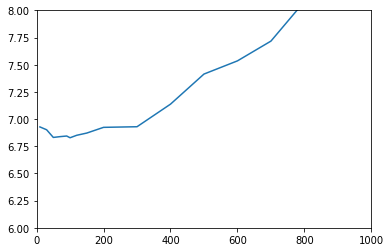

In [64]:
from sklearn.linear_model import LinearRegression

N = 3000
x_temp = np.zeros((0,))
y_temp = np.zeros((0,))
for n_comp in [10, 30, 50, 70, 90, 100, 120, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1500, 3000]:
    print('\n==== component number %d ====' % n_comp)
    reg = LinearRegression().fit(X[:N, :n_comp], Y[:N])
    print(reg.score(X[:N, :n_comp], Y[:N]))
    y2 = reg.predict(X[:N, :n_comp])
    mae = np.abs(y2 - Y[:N]).mean()
    var = np.mean((y2 - Y[:N])**2)
    print('Training MAE = %.3f, VAR = %.3f' % (mae, var))
    y2 = reg.predict(X[N:, :n_comp])
    mae = np.abs(y2 - Y[N:]).mean()
    var = np.mean((y2 - Y[N:])**2)
    print('Validation MAE = %.3f, VAR = %.3f' % (mae, var))
    x_temp = np.concatenate((x_temp, np.array((n_comp, ))))
    y_temp = np.concatenate((y_temp, np.array((mae, ))))
plt.plot(x_temp, y_temp)
plt.ylim([6, 8])
plt.xlim([0, 1000])

## NN

In [94]:
class scalar_record(dict):
    def __init__(self):
        super(scalar_record).__init__()
    def add(self, key, value):
        if not key in self.keys():
            self[key] = np.zeros(0)
        self[key] = np.concatenate((self[key], np.array((value,))))
    def plot(self):
        for key in self.keys():
            plt.plot(self[key],label=key)
        plt.grid(True)
        plt.legend()

In [114]:
class PcaNN(nn.Module):
    def __init__(self, n_input):
        super(PcaNN, self).__init__()
        self.module = nn.Sequential(
            nn.Linear(n_input, 64),
            nn.BatchNorm1d(64),            
            nn.ReLU(),          
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),  
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 40)
        )
    def forward(self, x):
        x = self.module(x)
        x = F.log_softmax(x, dim=1)
        return x

i=   0, loss=2.249, mae=8.034, mae_test=7.581, var_test=87.993
i=   1, loss=2.248, mae=8.034, mae_test=7.578, var_test=87.950
i=   2, loss=2.248, mae=8.033, mae_test=7.577, var_test=87.924
i=   3, loss=2.247, mae=8.032, mae_test=7.575, var_test=87.893
i=   4, loss=2.246, mae=8.031, mae_test=7.573, var_test=87.856
i=   5, loss=2.245, mae=8.030, mae_test=7.570, var_test=87.817
i=   6, loss=2.243, mae=8.028, mae_test=7.568, var_test=87.777
i=   7, loss=2.241, mae=8.025, mae_test=7.566, var_test=87.737
i=   8, loss=2.239, mae=8.023, mae_test=7.564, var_test=87.697
i=   9, loss=2.236, mae=8.020, mae_test=7.561, var_test=87.656
i=  10, loss=2.233, mae=8.017, mae_test=7.559, var_test=87.615
i=  11, loss=2.230, mae=8.013, mae_test=7.557, var_test=87.573
i=  12, loss=2.227, mae=8.009, mae_test=7.555, var_test=87.533
i=  13, loss=2.223, mae=8.005, mae_test=7.552, var_test=87.491
i=  14, loss=2.219, mae=8.001, mae_test=7.550, var_test=87.450
i=  15, loss=2.215, mae=7.996, mae_test=7.548, var_test

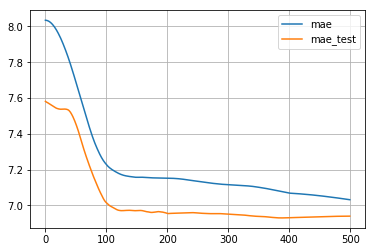

6.929522598849778
78.33343682091736


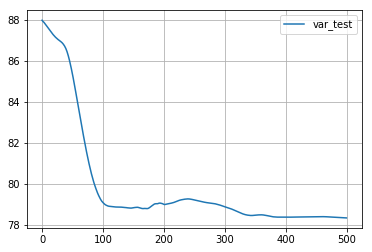

In [115]:
N = 3000
n_input_features = 50

data = torch.tensor(X[:N, :n_input_features], dtype=torch.float32)
label = torch.tensor(Y[:N], dtype=torch.float32)

data_test = torch.tensor(X[N:, :n_input_features], dtype=torch.float32)
label_test = torch.tensor(Y[N:], dtype=torch.float32)

target, bc = num2vect(label, [-44, 36], 2, 2)
target = torch.tensor(target, dtype=torch.float32)

N_epoch = 500

model = PcaNN(n_input_features)

learning_rate = 0.003
momentum = 0.2
weight_decay = 0.001

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum,
                      weight_decay=weight_decay)
optimizer.zero_grad()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.3) 

train_log = scalar_record()
train_log2 = scalar_record()

for i in range(N_epoch):
    model.train()
    out = model(data)
    loss = F.kl_div(out, target, reduction='sum')/N
    prob = np.exp(out.detach().numpy())
    pred_age = np.dot(prob,bc)
    d = pred_age - label
    mae = np.abs(d).mean()
    loss.backward()
    with torch.no_grad():
        model.eval()
        out = model(data_test)
        prob = np.exp(out.numpy())
        pred_age = np.dot(prob,bc)
        d_test = pred_age - label_test
        mae_test = np.abs(d_test).mean()
        var_test = (d_test**2).mean()
    train_log.add('mae', mae)
    train_log.add('mae_test', mae_test)
    train_log2.add('var_test', var_test)
    optimizer.step()
    scheduler.step()
    if (i+1)%1==0:
        print('i=%4d, loss=%.3f, mae=%.3f, mae_test=%.3f, var_test=%.3f' % (i, loss, mae, mae_test, var_test))
train_log.plot()
plt.show()
train_log2.plot()
print(train_log['mae_test'].min())
print(train_log2['var_test'].min())

## Regression

i=   0, loss=83.076, mae=7.192, mae_test=6.954, var_test=78.472
i=   1, loss=83.032, mae=7.190, mae_test=6.954, var_test=78.472
i=   2, loss=82.949, mae=7.186, mae_test=6.954, var_test=78.471
i=   3, loss=82.846, mae=7.181, mae_test=6.954, var_test=78.468
i=   4, loss=82.745, mae=7.176, mae_test=6.954, var_test=78.464
i=   5, loss=82.654, mae=7.172, mae_test=6.954, var_test=78.459
i=   6, loss=82.568, mae=7.168, mae_test=6.954, var_test=78.454
i=   7, loss=82.489, mae=7.165, mae_test=6.954, var_test=78.448
i=   8, loss=82.418, mae=7.162, mae_test=6.954, var_test=78.442
i=   9, loss=82.339, mae=7.159, mae_test=6.954, var_test=78.437
i=  10, loss=82.236, mae=7.154, mae_test=6.954, var_test=78.432
i=  11, loss=82.107, mae=7.149, mae_test=6.954, var_test=78.429
i=  12, loss=81.946, mae=7.142, mae_test=6.954, var_test=78.425
i=  13, loss=81.748, mae=7.134, mae_test=6.955, var_test=78.420
i=  14, loss=81.503, mae=7.124, mae_test=6.955, var_test=78.413
i=  15, loss=81.207, mae=7.112, mae_test

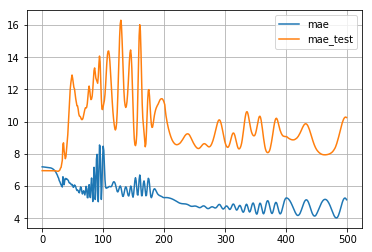

6.913979530334473
78.1686019897461


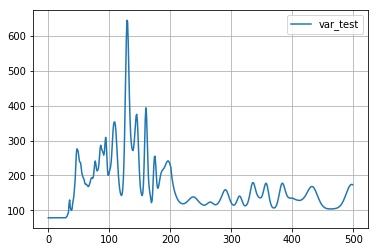

In [124]:
class PcaNN(nn.Module):
    def __init__(self, n_input):
        super(PcaNN, self).__init__()
        self.module = nn.Sequential(
            nn.Linear(n_input, 64),
            nn.BatchNorm1d(64),            
            nn.ReLU(),          
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),  
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        x = self.module(x)
        return x.reshape(-1)
    

N = 3000
n_input_features = 50

data = torch.tensor(X[:N, :n_input_features], dtype=torch.float32)
label = torch.tensor(Y[:N], dtype=torch.float32)

data_test = torch.tensor(X[N:, :n_input_features], dtype=torch.float32)
label_test = torch.tensor(Y[N:], dtype=torch.float32)

target = label

N_epoch = 500

model = PcaNN(n_input_features)

learning_rate = 0.003
momentum = 0.2
weight_decay = 0.001

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum,
                      weight_decay=weight_decay)
optimizer.zero_grad()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.3) 

train_log = scalar_record()
train_log2 = scalar_record()

for i in range(N_epoch):
    model.train()
    out = model(data)
    loss = F.mse_loss(out, target, reduction='sum')/N
    pred_age = out.detach().numpy()
    d = pred_age - label
    mae = np.abs(d).mean()
    loss.backward()
    with torch.no_grad():
        model.eval()
        out = model(data_test)
        pred_age = out
        d_test = pred_age - label_test
        mae_test = np.abs(d_test).mean()
        var_test = (d_test**2).mean()
    train_log.add('mae', mae)
    train_log.add('mae_test', mae_test)
    train_log2.add('var_test', var_test)
    optimizer.step()
    scheduler.step()
    if (i+1)%1==0:
        print('i=%4d, loss=%.3f, mae=%.3f, mae_test=%.3f, var_test=%.3f' % (i, loss, mae, mae_test, var_test))
train_log.plot()
plt.show()
train_log2.plot()
print(train_log['mae_test'].min())
print(train_log2['var_test'].min())